In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [8]:
# MPC import
from LinearMPC.MPCVelControl import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis,plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

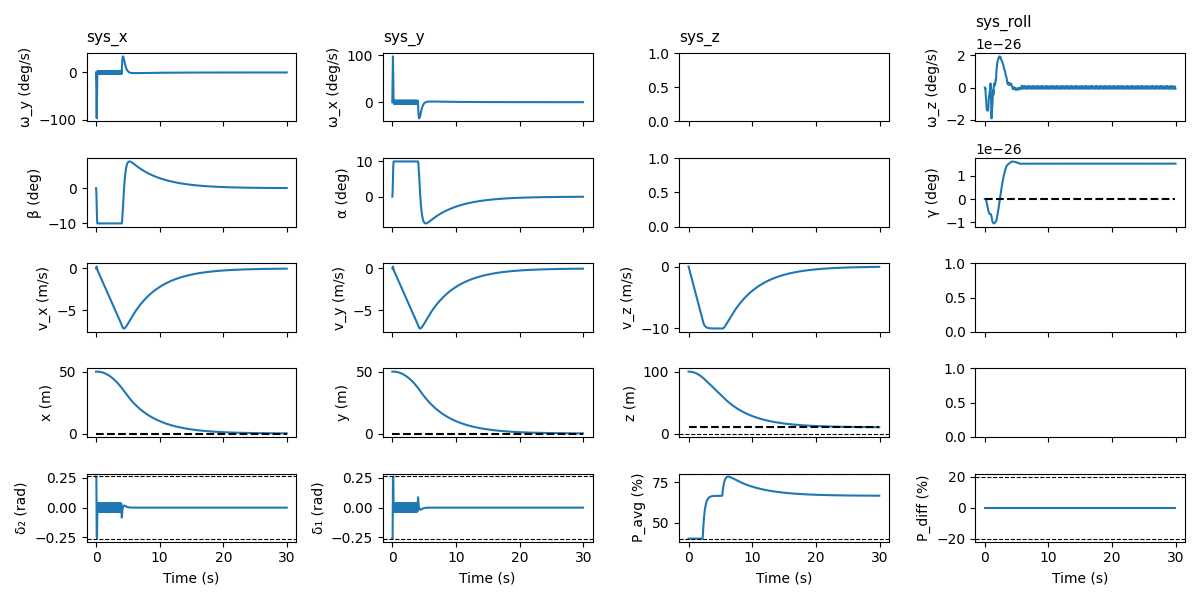

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=599, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x23d3b667530>,
 'scene_objects': {'rocket_actor': Actor (0x23d3b6e5f00)
    Center:                     (50.32007, 49.9984915, 100.58848449999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    4.936E+01, 5.128E+01
    Y Bounds                    4.879E+01, 5.121E+01
    Z Bo

In [9]:
# Simulation parameters
Ts = 0.05
sim_time = 30  # Increased from 20s to allow full convergence
H = 5.0

# Initial state: high altitude and velocity as specified
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])

x_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10])   # target state

# Target: stationary point at [0, 0, 10]m with roll = 0°
pos_target = np.array([0, 0, 10.0])

# Initialize rocket
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# Initialize PI position controller (already tuned)
pos_controller = PIControl(pos_target)

# Initialize MPC velocity controller
mpc = MPCVelControl().new_controller(rocket, Ts, H)



# Run closed-loop simulation with PI position controller
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="linear"
)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, x_target)
# Visualize
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

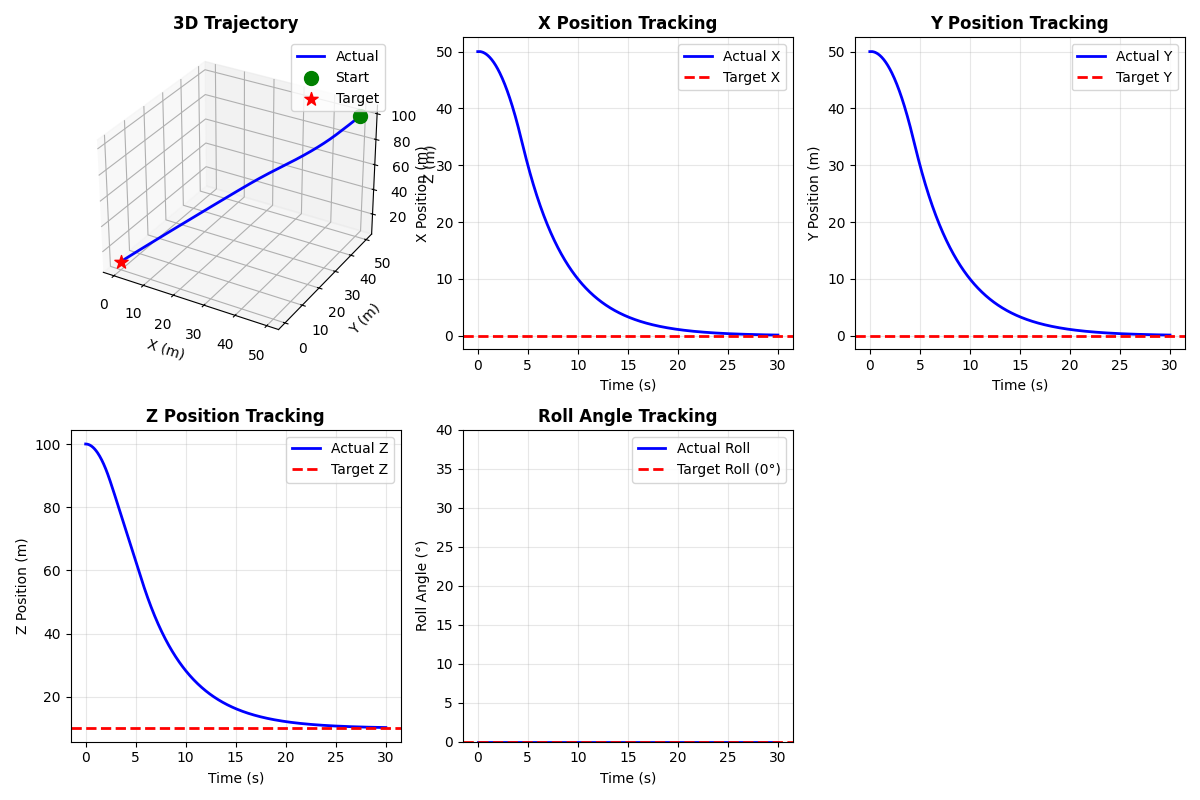

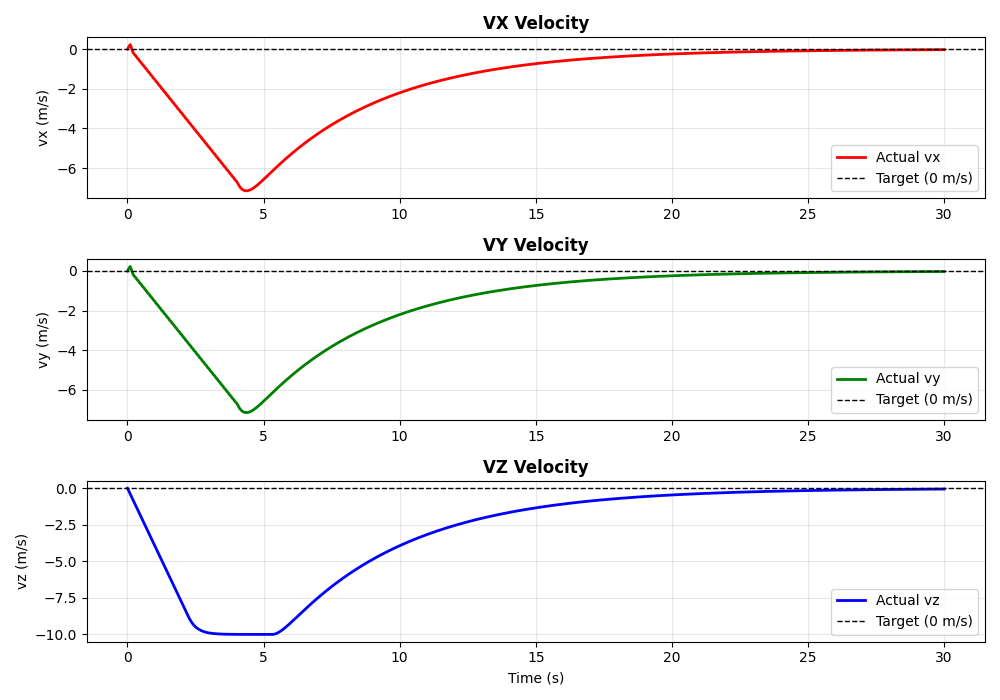

In [11]:
# Closed-loop performance plots
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

# Subplot 1: 3D trajectory
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.plot(x_cl[9, :], x_cl[10, :], x_cl[11, :], 'b-', linewidth=2, label='Actual')
ax1.scatter(x0[9], x0[10], x0[11], c='g', s=100, marker='o', label='Start')
ax1.scatter(pos_target[0], pos_target[1], pos_target[2], c='r', s=100, marker='*', label='Target')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('3D Trajectory', fontweight='bold')
ax1.legend()
ax1.grid(True)

# Subplot 2: X position
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(t_cl, x_cl[9, :], 'b-', linewidth=2, label='Actual X')
ax2.axhline(pos_target[0], color='r', linestyle='--', linewidth=2, label='Target X')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('X Position (m)')
ax2.set_title('X Position Tracking', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Subplot 3: Y position
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(t_cl, x_cl[10, :], 'b-', linewidth=2, label='Actual Y')
ax3.axhline(pos_target[1], color='r', linestyle='--', linewidth=2, label='Target Y')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Y Position (m)')
ax3.set_title('Y Position Tracking', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Z position
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(t_cl, x_cl[11, :], 'b-', linewidth=2, label='Actual Z')
ax4.axhline(pos_target[2], color='r', linestyle='--', linewidth=2, label='Target Z')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Z Position (m)')
ax4.set_title('Z Position Tracking', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Subplot 5: Roll angle
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(t_cl, np.rad2deg(x_cl[5, :]), 'b-', linewidth=2, label='Actual Roll')
ax5.axhline(0.0, color='r', linestyle='--', linewidth=2, label='Target Roll (0°)')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Roll Angle (°)')
ax5.set_title('Roll Angle Tracking', fontweight='bold')
ax5.set_ybound(0,40)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Subplot 6: Position error norm
# ax6 = fig.add_subplot(2, 3, 6)
# pos_error = np.linalg.norm(x_cl[9:12, :] - pos_target.reshape(-1, 1), axis=0)
# ax6.plot(t_cl, pos_error, 'r-', linewidth=2)
# ax6.set_xlabel('Time (s)')
# ax6.set_ylabel('Position Error (m)')
# ax6.set_title('3D Position Error', fontweight='bold')
# ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional velocity plot
fig2, axes = plt.subplots(3, 1, figsize=(10, 7))

# Velocity components
for i, (ax, label, color) in enumerate(zip(axes, ['vx', 'vy', 'vz'], ['r', 'g', 'b'])):
    ax.plot(t_cl, x_cl[6+i, :], color=color, linewidth=2, label=f'Actual {label}')
    ax.axhline(0, color='k', linestyle='--', linewidth=1, label='Target (0 m/s)')
    ax.set_ylabel(f'{label} (m/s)')
    ax.set_title(f'{label.upper()} Velocity', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()
